<a href="https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/tutorials/3_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [1]:
# Copyright 2021 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Training

This notebook demonstrates the libraries in [https://github.com/magenta/ddsp/tree/master/ddsp/training](https://github.com/magenta/ddsp/tree/master/ddsp/training). It is a simple example, overfitting a single audio sample, for educational purposes. 

_For a full training pipeline please use [ddsp/training/ddsp_run.py](https://github.com/magenta/ddsp/blob/master/ddsp/training/README.md#train-1) as in the [train_autoencoder.ipynb](https://github.com/magenta/ddsp/blob/master/ddsp/colab/demos/train_autoencoder.ipynb)_.



In [2]:
# Install and import dependencies
%tensorflow_version 2.x
!pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers)
from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = DEFAULT_SAMPLE_RATE  # 16000

     |████████████████████████████████| 174kB 7.9MB/s 
     |████████████████████████████████| 215kB 13.3MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 3.8MB 14.5MB/s 
     |████████████████████████████████| 5.6MB 26.1MB/s 
     |████████████████████████████████| 368kB 54.5MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 


# Get a batch of data

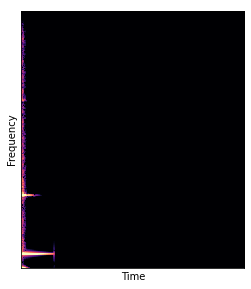

In [3]:
# Get a single example from NSynth.
# Takes a few seconds to load from GCS.
data_provider = data.NSynthTfds(split='test')
dataset = data_provider.get_batch(batch_size=1, shuffle=False).take(1).repeat()
batch = next(iter(dataset))
audio = batch['audio']
n_samples = audio.shape[1]

specplot(audio)
play(audio)

# Get a distribution strategy


In [4]:
strategy = train_util.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Get model and trainer

## python 

In [5]:
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                input_keys = ('ld_scaled', 'f0_scaled'),
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
  # Put it together in a model.
  model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
  trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)

## or [`gin`](https://github.com/google/gin-config)

In [6]:
gin_string = """
import ddsp
import ddsp.training

# Preprocessor
models.Autoencoder.preprocessor = @preprocessing.F0LoudnessPreprocessor()
preprocessing.F0LoudnessPreprocessor.time_steps = 1000


# Encoder
models.Autoencoder.encoder = None

# Decoder
models.Autoencoder.decoder = @decoders.RnnFcDecoder()
decoders.RnnFcDecoder.rnn_channels = 256
decoders.RnnFcDecoder.rnn_type = 'gru'
decoders.RnnFcDecoder.ch = 256
decoders.RnnFcDecoder.layers_per_stack = 1
decoders.RnnFcDecoder.input_keys = ('ld_scaled', 'f0_scaled')
decoders.RnnFcDecoder.output_splits = (('amps', 1),
                                       ('harmonic_distribution', 20),
                                       ('noise_magnitudes', 20))

# ProcessorGroup
models.Autoencoder.processor_group = @processors.ProcessorGroup()

processors.ProcessorGroup.dag = [
  (@harmonic/synths.Harmonic(),
    ['amps', 'harmonic_distribution', 'f0_hz']),
  (@noise/synths.FilteredNoise(),
    ['noise_magnitudes']),
  (@add/processors.Add(),
    ['noise/signal', 'harmonic/signal']),
]

# Harmonic Synthesizer
harmonic/synths.Harmonic.name = 'harmonic'
harmonic/synths.Harmonic.n_samples = 64000
harmonic/synths.Harmonic.scale_fn = @core.exp_sigmoid

# Filtered Noise Synthesizer
noise/synths.FilteredNoise.name = 'noise'
noise/synths.FilteredNoise.n_samples = 64000
noise/synths.FilteredNoise.window_size = 0
noise/synths.FilteredNoise.scale_fn = @core.exp_sigmoid
noise/synths.FilteredNoise.initial_bias = -10.0

# Add
add/processors.Add.name = 'add'

models.Autoencoder.losses = [
    @losses.SpectralLoss(),
]
losses.SpectralLoss.loss_type = 'L1'
losses.SpectralLoss.mag_weight = 1.0
losses.SpectralLoss.logmag_weight = 1.0
"""

with gin.unlock_config():
  gin.parse_config(gin_string)

with strategy.scope():
  # Autoencoder arguments are filled by gin.
  model = ddsp.training.models.Autoencoder()
  trainer = trainers.Trainer(model, strategy, learning_rate=1e-4)

# Train

## Build model

In [7]:
# Build model, easiest to just run forward pass.
dataset = trainer.distribute_dataset(dataset)
trainer.build(next(iter(dataset)))

Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor_1 ( multiple                  0         
_________________________________________________________________
rnn_fc_decoder_1 (RnnFcDecod multiple                  801321    
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________________________________________________________
spectral_loss (SpectralLoss) multiple                  0         
Total params: 801,321
Trainable params: 801,321
Non-trainable params: 0
_________________________________________________________________


## Train Loop

In [8]:
dataset_iter = iter(dataset)

for i in range(300):
  losses = trainer.train_step(dataset_iter)
  res_str = 'step: {}\t'.format(i)
  for k, v in losses.items():
    res_str += '{}: {:.2f}\t'.format(k, v)
  print(res_str)

step: 0	spectral_loss: 6.94	total_loss: 6.94	
step: 1	spectral_loss: 6.01	total_loss: 6.01	
step: 2	spectral_loss: 5.44	total_loss: 5.44	
step: 3	spectral_loss: 4.70	total_loss: 4.70	
step: 4	spectral_loss: 4.20	total_loss: 4.20	
step: 5	spectral_loss: 3.88	total_loss: 3.88	
step: 6	spectral_loss: 3.49	total_loss: 3.49	
step: 7	spectral_loss: 3.14	total_loss: 3.14	
step: 8	spectral_loss: 3.43	total_loss: 3.43	
step: 9	spectral_loss: 3.36	total_loss: 3.36	
step: 10	spectral_loss: 3.32	total_loss: 3.32	
step: 11	spectral_loss: 3.28	total_loss: 3.28	
step: 12	spectral_loss: 3.18	total_loss: 3.18	
step: 13	spectral_loss: 3.13	total_loss: 3.13	
step: 14	spectral_loss: 3.08	total_loss: 3.08	
step: 15	spectral_loss: 2.98	total_loss: 2.98	
step: 16	spectral_loss: 2.88	total_loss: 2.88	
step: 17	spectral_loss: 2.83	total_loss: 2.83	
step: 18	spectral_loss: 2.82	total_loss: 2.82	
step: 19	spectral_loss: 2.80	total_loss: 2.80	
step: 20	spectral_loss: 2.75	total_loss: 2.75	
step: 21	spectral_loss:

# Analyze results

In [9]:
# Run a batch of predictions.
start_time = time.time()
controls =  model(next(dataset_iter))
audio_gen = model.get_audio_from_outputs(controls)
print('Prediction took %.1f seconds' % (time.time() - start_time))

Prediction took 2.6 seconds


Original Audio


Resynthesized Audio


Filtered Noise Audio


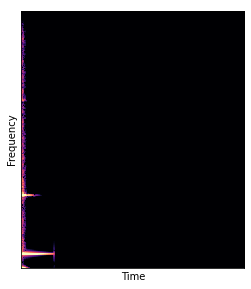

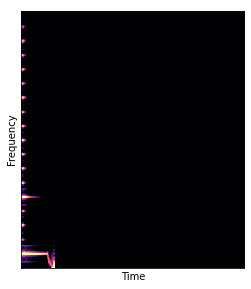

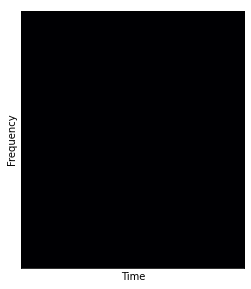

In [14]:
print('Original Audio')
play(audio)
print('Resynthesized Audio')
play(audio_gen)
print('Filtered Noise Audio')
audio_noise = controls['noise']['signal']
play(audio_noise)

specplot(audio)
specplot(audio_gen)
specplot(audio_noise)

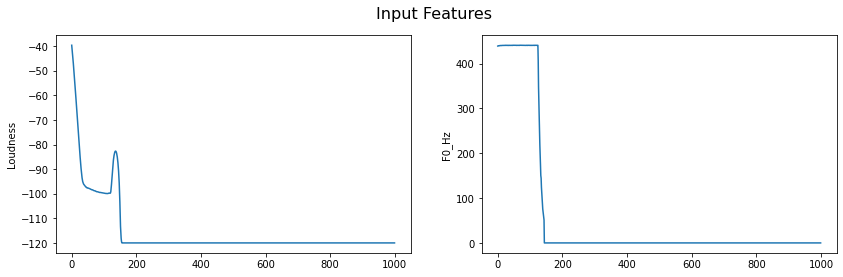

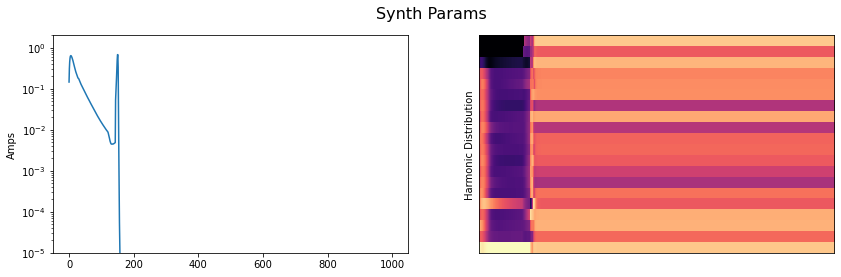

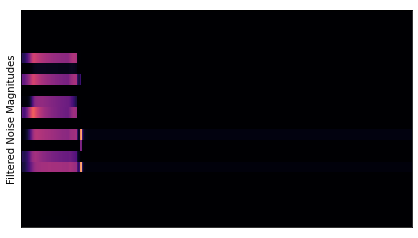

In [11]:
batch_idx = 0
get = lambda key: ddsp.core.nested_lookup(key, controls)[batch_idx]

amps = get('harmonic/controls/amplitudes')
harmonic_distribution = get('harmonic/controls/harmonic_distribution')
noise_magnitudes = get('noise/controls/magnitudes')
f0_hz = get('f0_hz')
loudness = get('loudness_db')

audio_noise = get('noise/signal')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Input Features', fontsize=16)
ax[0].plot(loudness)
ax[0].set_ylabel('Loudness')
ax[1].plot(f0_hz)
ax[1].set_ylabel('F0_Hz')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Synth Params', fontsize=16)
ax[0].semilogy(amps)
ax[0].set_ylabel('Amps')
ax[0].set_ylim(1e-5, 2)
# ax[0].semilogy(harmonic_distribution)
ax[1].matshow(np.rot90(np.log10(harmonic_distribution + 1e-6)),
              cmap=plt.cm.magma, 
              aspect='auto')
ax[1].set_ylabel('Harmonic Distribution')
ax[1].set_xticks([])
_ = ax[1].set_yticks([])

f, ax = plt.subplots(1, 1, figsize=(7, 4))
# f.suptitle('Filtered Noise Params', fontsize=16)
ax.matshow(np.rot90(np.log10(noise_magnitudes + 1e-6)), 
           cmap=plt.cm.magma, 
           aspect='auto')
ax.set_ylabel('Filtered Noise Magnitudes')
ax.set_xticks([])
_ = ax.set_yticks([])
